Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- density of shops [DONE]
- isochrone from geocoded point
- betweenness centrality of street intersections [DONE]

Step 1: Import packages

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

In [2]:
# Set name for Nominatim query
query = "Santa Mesa, Manila"
buffer_dist = 7_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

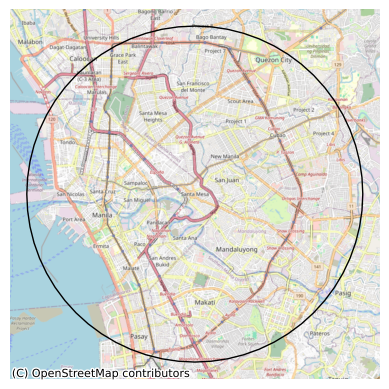

In [3]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

In [4]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True,
    simplify=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [5]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [6]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([ 1,  2,  4,  3,  5,  8,  6, 10,  7])

In [7]:
streets.head()

osmid                   name      highway  \
u        v          key                                                  
12067302 1686647100 0      2667105     E. Manaloto Street  residential   
         2950125788 0    224039651  F. B. Harrison Street    secondary   
         6510185271 0    224039651  F. B. Harrison Street    secondary   
12067308 8562405196 0    224039655  F. B. Harrison Street    secondary   
12067317 21590567   0      4075803                    NaN      service   

                         oneway reversed   length  lanes maxspeed width  \
u        v          key                                                   
12067302 1686647100 0     False     True  129.271      1      NaN   NaN   
         2950125788 0     False    False   34.788      2       40     8   
         6510185271 0     False     True   64.713      2       40     8   
12067308 8562405196 0     False     True    6.000      2       40     8   
12067317 21590567   0     False    False   20.803      1      NaN   NaN   

                                                                  geometry  \
u        v          key                                                      
12067302 1686647100 0    LINESTRING (13469098.694 1636416.366, 13468968...   
         2950125788 0    LINESTRING (13469098.694 1636416.366, 13469106...   
         6510185271 0    LINESTRING (13469098.694 1636416.366, 13469090...   
12067308 8562405196 0    LINESTRING (13469183.352 1635997.883, 13469182...   
12067317 21590567   0    LINESTRING (13468784.784 1636316.118, 13468806...   

                         ref access junction tunnel service bridge  
u        v          key                                             
12067302 1686647100 0    NaN    NaN      NaN    NaN     NaN    NaN  
         2950125788 0    NaN    NaN      NaN    NaN     NaN    NaN  
         6510185271 0    NaN    NaN      NaN    NaN     NaN    NaN  
12067308 8562405196 0    NaN    NaN      NaN    NaN     NaN    NaN  
12067317 21590567   0    NaN    NaN      NaN    NaN     NaN    NaN

Step 4: Plotting the street network and intersection heatmap

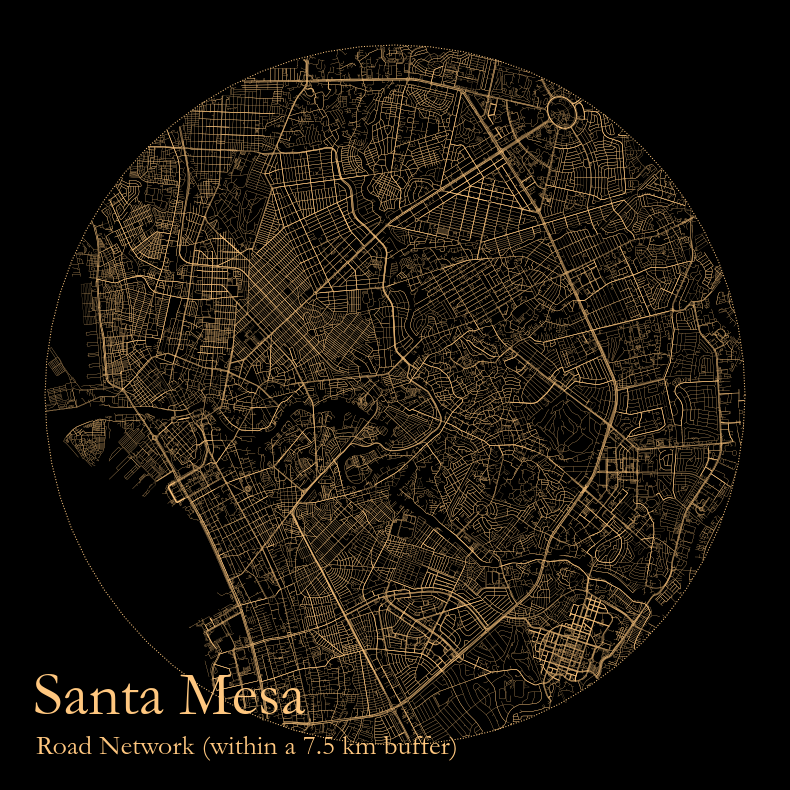

In [8]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    width_factor=0.1,
    color_scheme="copper"
)

# plot_heatmap(
#     intersections,
#     "street_count",
#     bins=500,
#     ax=ax,
#     alpha=0.7,
#     color_scheme="BuPu_r",
#     bounds=ring_bounds
# )

Part B: Generating a heatmap for other POIs

Step 1: Extract POIs within buffer

In [19]:
# Extract all shops within the buffer
pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        # "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
        "building:levels": [str(i) for i in range(30,100)],
    }
)

# Examine number of rows and columns
pois.shape

(779, 75)

Step 2: Clean up POI data

In [20]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
pois = drop_nan_cols(pois, 0.75)

In [21]:
# Examine # of rows & cols after pre-processing
pois.shape

(779, 7)

In [22]:
# Flatten column indices
# (this should be in the function)
pois = pois.reset_index()

pois.head()

,element_type,osmid,geometry,name,nodes,building,building:levels,height,building:part
0,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Philamlife Tower,"[244891956, 244891957, 244891958, 244891959, 2...",commercial,48,200,NaN
1,way,23394981,"POLYGON ((121.07980 14.60738, 121.07965 14.607...",IBM Plaza,"[253295593, 253295592, 253295642, 1210079208, ...",yes,32,NaN,NaN
2,way,24547895,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",Rizal Tower,"[266905127, 2312911335, 2312911334, 2312911330...",apartments,47,161,NaN
3,way,24547947,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",Luna Gardens,"[266905163, 266905164, 266905165, 266905166, 2...",apartments,39,134.9,NaN
4,way,24547950,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",Amorsolo East,"[266905215, 266905216, 266905217, 266905218, 2...",residential,30,107,NaN


In [23]:
# Assign weight to all POIs (for heatmap)
pois["weight"] = 1.0

In [24]:
# Reproject to Pseudo-Mercator
pois = pois.to_crs("EPSG:3857")

In [25]:
# Set feature geometries as their centroids
# (this should be in the function)
pois["geometry"] = pois["geometry"].centroid
pois.shape

(779, 10)

In [32]:
pois["building:levels"] = pois["building:levels"].apply(
    lambda x: max(x) if isinstance(x, list) == True else x
)

pois["building:levels"] = pois["building:levels"].astype(int)

Step 3: Plot POI density heatmap

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


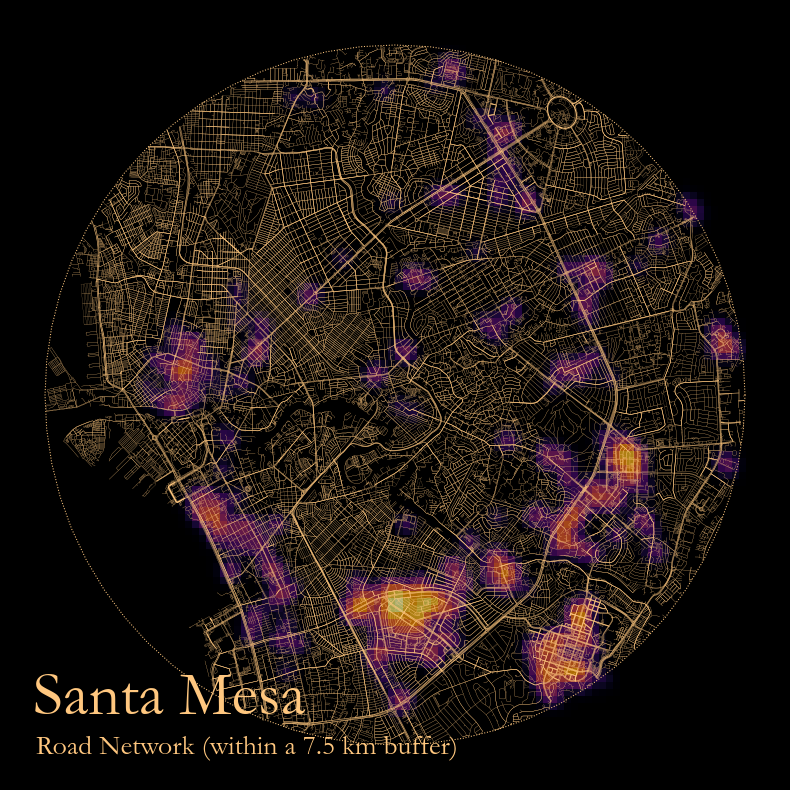

In [35]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    width_factor=0.1,
    color_scheme="copper"
)

plot_heatmap(
    pois,
    "building:levels",
    bins=100,
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)

Part C: Visualizing betweenness centrality of street intersections

Step 1: Calculate betweenness centrality per node

In [17]:
len(intersections)

47870

In [18]:
# Can't run for very big networks, even with k ~= 1% of total no. of nodes
bc = nx.betweenness_centrality(graph, weight="street_count", k=1_000)

KeyboardInterrupt: 

Step 2: Join betweenness values to each node via osmid

In [ ]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

In [ ]:
intersections, streets = ox.graph_to_gdfs(graph)

In [ ]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [ ]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

In [ ]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

In [ ]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.9,
    color_scheme="inferno",
    bounds=ring_bounds
)